In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import open3d as o3d
import tensorflow as tf
import pandas as pd
import math

In [11]:
# ------------------real data-----------------------------
TRAIN_BASE_DIR = "datasets/small_obs_dataset/Small_Obstacle_Dataset/train"
VAL_BASE_DIR = "datasets/small_obs_dataset/Small_Obstacle_Dataset/val"
TEST_BASE_DIR = "datasets/small_obs_dataset/Small_Obstacle_Dataset/test"

LABELS_DIR = "/labels"
IMAGE_DIR = "/image"
ODOMETRY_DIR = "/odometry"
VELODYNE_DIR = "/velodyne"

# View Lidar data

In [12]:
def show_point_cloud(pcd):
    pcd = pcd[:, :3]
    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(pcd)
    o3d.visualization.draw_geometries([point_cloud])


def view_lidar_3d(base_dir, input_file_name):
    lidar_path = os.path.join(base_dir, input_file_name).replace('\\', '/')
    pcd = np.load(lidar_path)
    show_point_cloud(pcd)

In [13]:
# real road scenario
view_lidar_3d(TRAIN_BASE_DIR + "/file_1" + VELODYNE_DIR, "0000000080.npy")

In [14]:
def save_to_csv(output_path, headers, data):
    with open(output_path, 'w', newline='') as file:
        writer = csv.writer(file)
        # write headers in first row
        writer.writerow(headers)
        # write the data from the given list
        for row in data:
            writer.writerow(row)

# Load Lidar data

In [15]:
def load_lidar_data(root_dir):
    lidar_data = []
    calibration_data = []
    i = 0
    for root, dirs, files in os.walk(root_dir):
        if root.endswith("velodyne"):
            files = [os.path.join(root, f).replace("\\", "/") for f in files if f.endswith('.npy')]
            lidar_data += list(map(lambda f: [f, i], files))
            i += 1
        calibration_data += [os.path.join(root, f).replace("\\", "/") for f in files if f.endswith('.txt')]

    data = list(map(lambda e: [e[0], calibration_data[e[1]]], lidar_data))
    return data

In [16]:
train_lidar_csv_path = TRAIN_BASE_DIR + '/train_lidar.csv'
val_lidar_csv_path = VAL_BASE_DIR + '/val_lidar.csv'
test_lidar_csv_path = TEST_BASE_DIR + '/test_lidar.csv'

lidar_headers = ["lidar", "calibration"]

train_lidar_data = load_lidar_data(TRAIN_BASE_DIR)
print("Found %d train lidar npy files" % len(train_lidar_data))
# save to csv file
save_to_csv(train_lidar_csv_path, lidar_headers, train_lidar_data)

val_lidar_data = load_lidar_data(VAL_BASE_DIR)
print("Found %d validation lidar npy files" % len(val_lidar_data))
# save to csv file
save_to_csv(val_lidar_csv_path, lidar_headers, val_lidar_data)

test_lidar_data = load_lidar_data(TEST_BASE_DIR)
print("Found %d test lidar npy files" % len(test_lidar_data))
# save to csv file
save_to_csv(test_lidar_csv_path, lidar_headers, test_lidar_data)

train_lidar_df = pd.read_csv(train_lidar_csv_path)
print("Columns: ", train_lidar_df.columns.values)
print("Shape: ", train_lidar_df.shape)

train_lidar_df.head()

Found 5696 train lidar npy files
Found 1688 validation lidar npy files
Found 1130 test lidar npy files
Columns:  ['lidar' 'calibration']
Shape:  (5696, 2)


,lidar,calibration
0,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
1,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
2,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
3,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...
4,datasets/small_obs_dataset/Small_Obstacle_Data...,datasets/small_obs_dataset/Small_Obstacle_Data...


In [21]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32

In [22]:
def read_calibration_data(calibration_file):
    with open(calibration_file, 'r') as f:
        reader = csv.reader(f)
        coord = []
        for line in reader:
            if len(line) > 0 and len(line[0]) > 0 and line[0][0] != '#':
                # add each line which contains valid numbers (not comments '#' or empty strings ' '
                # remove the last token, which is the empty space at the end of each line
                coord.append(line[0].split(' ')[:-1])
        # convert the string values to float
        coord = np.asarray(coord, 'float64')
        # read 7x4 values, from which:
        ## first 3x4 values represent the intrinsic camera transformation matrix
        ## the next 4x4 values represent the extrinsic lidar-camera transformation matrix

        coord = np.reshape(coord, (7, 4))
        int_mat = coord[:3]
        ext_mat = coord[3:]

        return int_mat, ext_mat


def apply_camera_projection(points, camera_int, camera_ext):
    """
    :param points: lidar point cloud
    :param camera_int: convert from camera coord to image coord (u,v)
    :param camera_ext: convert from world coord to camera coord
    :return:
    """
    project = lambda p, camera_int, camera_ext: camera_int @ camera_ext.dot(p[:4])
    normalize = lambda p: (p / p[2])[:-1]
    points[:, 3] = 1
    return [normalize(project(p, camera_int, camera_ext)) for p in points]


def project_points_to_image(points, img_height, img_width):
    # create a white canvas on which the points wil be projected
    img_mat = np.full((img_height, img_width, 3), [255, 255, 255])
    for p in points:
        i = int(p[0]) % IMG_WIDTH
        j = int(p[1]) % IMG_HEIGHT
        img_mat[i][j] = [0, 0, 0]
    return img_mat


def load_and_preprocess_lidar(row):
    lidar_path = row[0]
    calibration_path = row[1]
    pcd = np.load(lidar_path)
    return pcd, calibration_path


def project_lidar_points(row):
    pcd = row[0]
    calibration_path = row[1]
    camera_int, camera_ext = read_calibration_data(calibration_path)
    camera_int[0][2] = IMG_WIDTH / 2
    camera_int[1][2] = IMG_HEIGHT / 2
    camera_int[0][0] = 1 / IMG_WIDTH
    camera_int[1][1] = 1 / IMG_HEIGHT
    plane_projection = apply_camera_projection(pcd, camera_int, camera_ext)
    img = project_points_to_image(plane_projection, IMG_HEIGHT, IMG_WIDTH)
    return img

In [23]:
# read point cloud data
train_lidar_pcd_df = train_lidar_df[:BATCH_SIZE].apply(load_and_preprocess_lidar, axis=1)
# project 3d point cloud to image plane using the calibration data
train_lidar_proj_df = train_lidar_pcd_df.apply(project_lidar_points)
train_lidar_tensor = tf.data.Dataset.from_tensor_slices(train_lidar_proj_df.tolist())
print(train_lidar_tensor.element_spec)

TensorSpec(shape=(180, 180, 3), dtype=tf.int32, name=None)


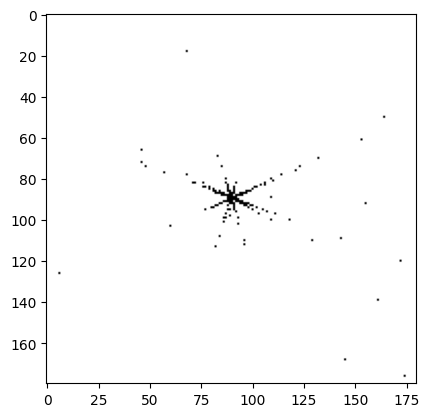

In [24]:
it = train_lidar_tensor.shuffle(len(train_lidar_proj_df.values)).batch(32).as_numpy_iterator()
sample_img = it.next()[0]
plt.imshow(sample_img)

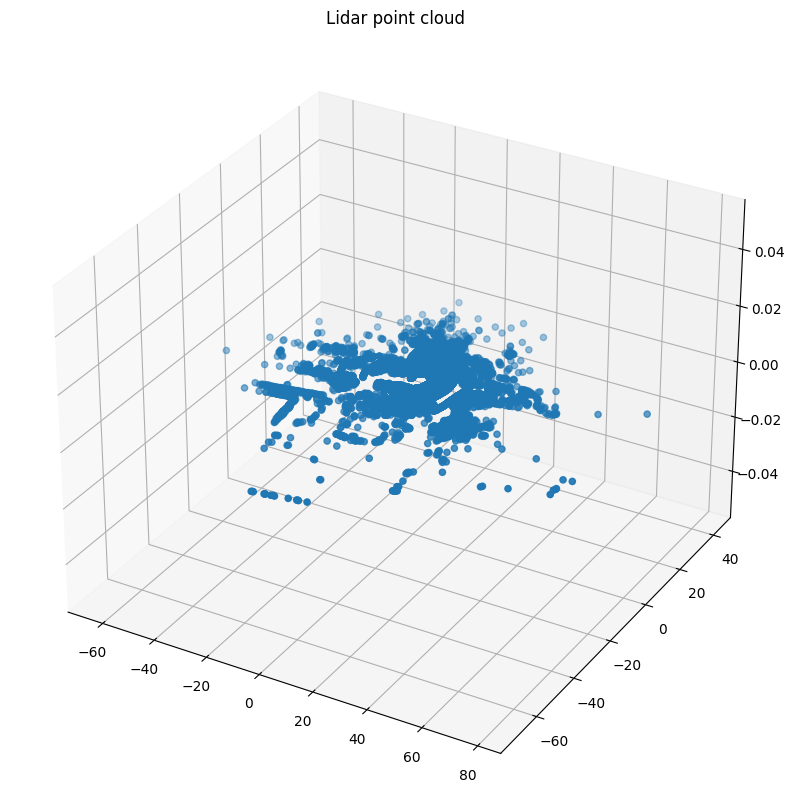

In [25]:
_ = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
ax.set_title("Lidar point cloud")
x = train_lidar_pcd_df[0][0][:,0]
y = train_lidar_pcd_df[0][0][:,1]
ax.scatter(x, y)
plt.show()

### Generate confidence maps from Lidar

First detect discontinuities in the lidar rings (breakpoints), then project the detected small obstacle segments onto the image plane.

In [26]:
def predict_distance(d1, d2, theta=2):
    theta = theta * math.pi / 180
    return (d1 * d2) / (d1 * math.cos(theta) - d2)


def is_breakpoint(d, dp, d_th=0.4):
    return abs(d - dp) >= d_th


def gradient_direction(d, dp):
    return (d - dp) / abs(d - dp) if d - dp != 0 else 0


def belongs_obstacle_segment(da, da_p, db, db_p):
    if is_breakpoint(db, db_p):
        ga = gradient_direction(da, da_p)
        gb = gradient_direction(db, db_p)
        return ga * gb < 0

    return False


breakpoints = []
N = train_lidar_pcd_df.shape[0]
for i in range(0, N):
    b = []
    p = train_lidar_pcd_df[i]
    M = len(p[0])
    da_p = 0
    da = 0
    for j in range(3, M):
        d1 = p[0][j - 2][3]
        d2 = p[0][j - 1][3]
        db_p = predict_distance(d1, d2)
        db = p[0][j][3]
        if belongs_obstacle_segment(da, da_p, db, db_p):
            b.append(p[0][j])
            da = db
            da_p = db_p

    breakpoints.append(np.asarray(b))

Use the label associated to the image data in order to segment the points which belong to the road surface or fall outside.

In [27]:
breakpoints = np.asarray(breakpoints, dtype=object)
# show_point_cloud(breakpoints[0])
print(len(breakpoints[4]))

0
